# Answers

You can edit this Jupyter notebook to include your answers and run any code that generates those answers or produces plots.  You can add additional cells for code or markdown as needed.

In [18]:
# Housekeeping #
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sympy as sym
import scipy.linalg as la
from scipy.fft import fft, ifft
from scipy.integrate import solve_ivp

## Problem 0
The Fourier transform, denoted by $\mathcal F$, can be used to solve differential equations. One can show that the Fourier transform of a derivative satisfies
$$\mathcal F\left[f'\right] = i \omega \mathcal F\left[f\right]$$
where the $\omega$ is the variable in the transformed space (i.e. frequency).
The above equation may differ by a constant depending on which convention you're using for the Fourier transform. 

To solve $u$ to the ODE
$u''(x) = g(x)$
on the domain $[0,2\pi]$ with periodic boundary constraints $u(0) = u(2\pi)$ and $g(0) = g(2\pi)$, we observe that
$$- \omega^2 \mathcal F[u]= \mathcal F[g].$$
Therefore 
$$u(x) = \mathcal F^{-1}\left[-\frac{1}{\omega^2}\mathcal F[g](\omega)\right](x).$$


This works great in theory, but often the right-hand side of the above equation is hard to compute in practice.

Instead, we discretize $g(x)$ on $[0,2\pi]$ by evaluating it at $N$ equally spaced points. This gives us a vector $\mathbf g\in\mathbb R^N$. Our goal is to find a vector $\mathbf u\in\mathbb R^N$ that is approximately equal to the evaluation of $u(x)$.
The discrete Fourier transform of $\mathbf g$ is approximately the same as the discretization of $\mathcal F[g]$, and similarly for $u$.

Because $\mathcal F$ is a linear transformation, the discrete Fourier transform of a function can be computed via multiplication of $\mathbf f$ by the appropriate matrix, which takes $O(N^2)$ time. However, in 1965, Cooley and Tukey developed [an algorithm](https://www.ams.org/journals/mcom/1965-19-090/S0025-5718-1965-0178586-1/) for computing the discrete Fourier transform in $O(N \log N)$ time. (The first part of [this webpage](https://www.cmlab.csie.ntu.edu.tw/cml/dsp/training/coding/transform/fft.html) gives a descent explanation of how this algorithm works.) Their fast Fourier transform and its inverse are implemented in `scipy.fft` as `fft` and `ifft`.
$\DeclareMathOperator{\fft}{fft}$

$\DeclareMathOperator{\ifft}{ifft}$
Putting this all together, we get that 
$$\mathbf u \approx \ifft(\;-\frac{1}{\omega^2}\;*\;\fft(\mathbf g)\;).$$

### Part A
Solve $u''(x) = -\sin(x)$ for $u$ with periodic boundary conditions using the Fast Fourier transform. Use $N=50$. Solve the equation analytically as well with $u(0) = u(2\pi) = 0$. Plot the solution you found with the FFT as well as the analytic solution with a legend and title. What is the maximum modulus of error on the evaluation points?  Because the Fourier transform is defined for complex variables, by using the FFT we introduce error by adding a small imaginary part to the solution. What is the largest imaginary value in your solution?

Hint: Because scipy rearranges which $\omega$ corresponds to which entry in the vector, $\fft(\mathbf g)$, you will need to be careful in how you divide by $\omega^2$. For $N$ even, 
- Entries $0$ to $N/2 - 1$ correspond to $\omega = 0,\ldots,N/2 - 1$
- Entries $N/2$ to $N-1$ correspond to $\omega = -N/2, \ldots, -1$.

Also, do not divide by $\omega^2$ for the term corresponding to $\omega = 0$.

The general solution is Eq(u(x), C1 + C2*x + sin(x)), with periodic boundary conditions we have u(x)=sin(x).


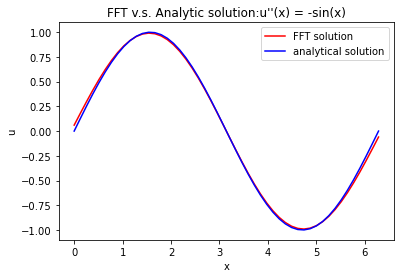

The maximum modulus of error on the evaluation points is 0.16455605873771303
the largest imaginary value in solution is 1.2819421261548929e-16


In [19]:
# Analytic solution 
x = sym.symbols('x')
g = - sym.sin(x)
u = sym.Function('u')(x)
eq = sym.Eq(u.diff(x,x), g)
print(f"The general solution is {sym.dsolve(eq, u)}, with periodic boundary conditions we have u(x)=sin(x).")

# Solve using the Fast Fourier transform
N = 50
x = np.linspace(0, 2*np.pi, N)
g = -np.sin(x)
ghat = fft(g)
w = np.hstack((range(0,int(N/2)), range(int(-N/2),0))) # returns the array of frequencies, corresponding to entries of FFT
w[0] = 1 # not divide by w2 for the term corresponding to w=0
u = ifft(-ghat/(w**2))
u_imag = np.imag(u) # imaginary part
u_real = np.real(u) # real part

# Plot the FFT solution and analytic solution
plt.plot(x, u_real, color = "r", label="FFT solution")
plt.plot(x, np.sin(x), color = "b", label="analytical solution")
plt.title('FFT v.s. Analytic solution:u\'\'(x) = -sin(x)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

# maximum modulus of error
maxerr = np.max(la.norm(u - np.sin(x)))
print(f"The maximum modulus of error on the evaluation points is {maxerr}")
# largest imaginary value
maximag = np.max(u_imag)
print(f"the largest imaginary value in solution is {maximag}")

### Part B
Solve $u''(x) = \exp(-(x-\pi)^2)$ for $u$ with periodic boundary conditions using the Fast Fourier transform. Use $N=50$. Plot the solution.

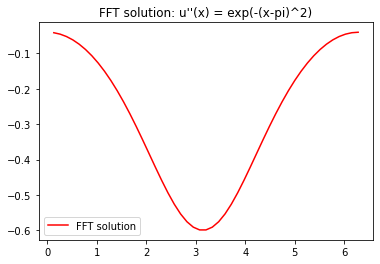

In [20]:
# Similar to Part A
N = 50
x = np.linspace(0, 2*np.pi, N)
x = x[1:50] # do not divide when w = 0
g = np.exp(-(x-np.pi)**2)
ghat = fft(g)
w = np.hstack((range(0,int(N/2)), range(int(-N/2),0)))
w = w[1:50] # do not divide when w = 0
u = ifft(-ghat/(w**2))
u_real = np.real(u)

plt.plot(x, u_real, color='r', label="FFT solution")
plt.title("FFT solution: u\'\'(x) = exp(-(x-pi)^2)")
plt.legend()
plt.show()

## Problem 1

Finding the global or local minimizer for a specific function is an ubiquitous task in applied sciences. Given a potential function $V(x)$,
\begin{equation}
V(x) = (x^2-1)^2 + 0.1*x,
\end{equation}
which is usually referred as the "double-well" potential. As locally convex function, it has two minimizers located in -1 and 1. There are multiple ways to find the minimizers of the function

### Part A
For a convex function or locally convex function, simple [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) with proper initial guess is a good candidate of minimization algorithm. Assume one starts with initial guess $x_0$, the gradient descent algorithm seeks a sequence of points $x_1,x_2,\cdots,x_n$ such that $x_{n}=x_{n-1} - \alpha_{n-1}\nabla V(x_{n-1})$, where $\alpha_{n-1}$ is the step size and $\nabla (x_{n-1})$ is the gradient of the given potential function at the current point. This procedure can also be considered as the **gradient flow** dynamics in the continuous sense:
\begin{equation}
\frac{dx_t}{dt} = -\nabla V(x_t).
\end{equation}
Try to find the minimizers of the double-well potential function by simulating the gradient flow ODE dynamics. Note that different initializations may lead to different minimizers (falling into different potential wells). You can use Scipy's ODE solver [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) with your preferred method or the Forward Euler solver you implemented in HW4.

### Part B
Another approach is the Newton's method we have covered in the class. We can also find the minimizers of the function by computing the critical points of its gradient. Write a function to use Newton's method to recover both local minimizers of $V$.

In [21]:
##############
### Part A ###
##############

f = lambda t, x : -(4 * x * (x**2 - 1) + 0.1) # - gradient of V

x0 = np.array([0])
t_span = (-1, 1)
t_eval = np.linspace(-1, 1, 1000)
sol_ivp = solve_ivp(f, t_span, x0, t_eval=t_eval)

# the minimum is value of sol_ivp with largest t, i.e. the last entry of sol_ivp.y
print('One local minimum (with initialization x = 0) is ',sol_ivp.y[0,-1])

# Another minimum with different initialization
x0 = np.array([1])
t_span = (-1,1)
t_eval = np.linspace(-1, 1, 1000)
sol_ivp = solve_ivp(f, t_span, x0, t_eval = t_eval)
print('Another local minimum (with initialization x = 1) is ',sol_ivp.y[0,-1])

One local minimum (with initialization x = 0) is  -1.0121812036077746
Another local minimum (with initialization x = 1) is  0.9875353243872366


In [22]:
##############
### Part B ###
##############

gradV = lambda x : 4 * x * (x**2 - 1) + 0.1 # gradient of V
ggradV = lambda x : 4 * (3*x**2 - 1) # gradient of gradient of V

def newton_root(f, fp, x=1, tol=1e-4):
    '''
    use Newton's method to find local minimizers
    
    inputs:
        f - function, gradV(x) in this part
        fp - derivative of function f, grad(gradV(x)) in this part
        x - starting point (default 1)
        tol - tolerance for terminating the algorithm (default 1e-4)
    '''
    fx = f(x)
    while (abs(f(x)) > tol):    
        x = x - f(x) / fp(x)
        fx = f(x)
    return x

print(f"One local minimum is {newton_root(gradV, ggradV,x=-1)}")
print(f"Another local minimum is {newton_root(gradV, ggradV,x=1)}")
print(f"The saddle point is {newton_root(gradV, ggradV,x=0)}")

One local minimum is -1.0122732063539863
Another local minimum is 0.9872575671508561
The saddle point is 0.025


## Problem 2

### Part A
Consider the following stochastic differential equation
\begin{equation}
dX_t = -\nabla V(X_t) dt + \sqrt{2\beta^{-1}} dW_t
\end{equation}
where $X_t\in\mathbb{R}$ is the state of the system, $W_t$ is a one-dimensional Wiener process and $\beta$ is a constant. This process is usually referred as the overdamped Langevin process. 

We can simulate the overdamped Langevin process by discrete-time method. One of the simplest is the Euler-Maruyama ethod with fixed time step. Please read [Euler-Maruyama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) for details. 

Implement the Euler-Maruyama simulator for $\beta=0.5$ and draw an ensemble of $10^4$ independent samples from the standard normal distribution $\mathcal{N}(0,1)$ as our initial samples. Simulate the sample path for each of the samples. Visualize the sample distribution using histograms for $t=0.02,0.06,0.1,0.5$. What do you observe and how do you explain your findings?

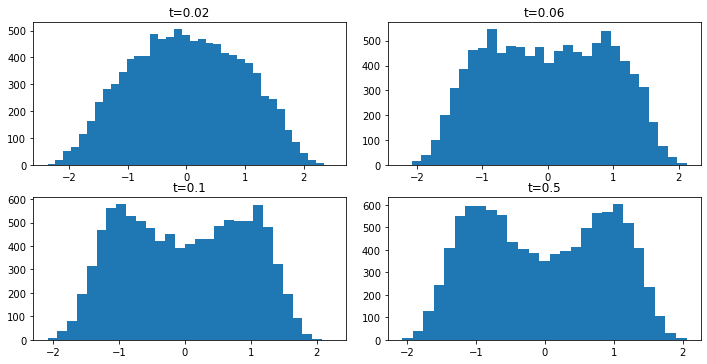

In [23]:
gradV = lambda x : 4 * x * (x**2 - 1) + 0.1 # gradient of V

beta = 0.5
dt=0.001 #set step size
nsample = 10000 # sample size
X0= np.random.randn(nsample)

def X(t):
    '''
    The state of overdamped Langevin process
    '''
    X=np.zeros(nsample)
    n=int(t/dt)
    Xi=X0
    for i in range(n):
        X = Xi - gradV(Xi) * dt + np.sqrt(2/beta) * np.sqrt(dt) * np.random.randn(nsample)
        Xi = X
    
    return X

# histograms of sample distribution
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.tight_layout() 
axs[0,0].hist(X(0.02),bins='auto')
axs[0,0].title.set_text('t=0.02')
axs[0,1].hist(X(0.06),bins='auto')
axs[0,1].title.set_text('t=0.06')
axs[1,0].hist(X(0.1),bins='auto')
axs[1,0].title.set_text('t=0.1')
axs[1,1].hist(X(0.5),bins='auto')
axs[1,1].title.set_text('t=0.5')
plt.show()

**Oberservation:**

When $t$ is small, the sample distribution is similar to the normal distribution, which is same as our initialization.

When $t$ is getting larger, the sample distribution tends to the shape of "double well". Besides, this process tends to be stationary when $t$ is large.

**Explanation:**

In physics, we can consider a particle moving in the "double-well" potential. At early times, this particle is not limited by the potential and just diffuses around from the initial distribution; At large times, the confining potential limits the fluctuations and the particle is undergoing small Brownian fluctuations close to the minimum of the potential well (in this case can be one of the "double well").

### Part B
The Fokker-Planck equation characterizes the evolution of the distribution of the samples. For the overdamped Langevin process discussed above, the corresponding Fokker-Planck equation is given by 
\begin{equation}
\frac{\partial p}{\partial t} = \nabla \cdot (\nabla Vp) + \frac{1}{\beta} \Delta p.
\end{equation}
Show the invariant distribution of the system is given by the Boltzmann-Gibbs distribution
\begin{equation}
p(x) \propto \exp{(-\beta V(x))}.
\end{equation}

**My Answer**:

First, for invariant distribution of the system, we need 
\begin{equation}
\frac{\partial p}{\partial t} = 0
\end{equation}

Then, we can rewrite the Fokker-Planck equation as:
\begin{equation}
\frac{\partial }{\partial x}(\frac{\partial V(x) }{\partial x}p(x))+ \frac{1}{\beta}\frac{\partial^2 p(x) }{\partial x^2}= 0
\end{equation}
\begin{equation}
\frac{\partial }{\partial x}(\frac{\partial V(x) }{\partial x}p(x)+ \frac{1}{\beta}\frac{\partial p(x) }{\partial x})= 0
\end{equation}
\begin{equation}
\frac{\partial V(x) }{\partial x}p(x)+ \frac{1}{\beta}\frac{\partial p(x) }{\partial x}= Constant
\end{equation}

Since the moment should be finite, we must have $p(x)$ and $\frac{\partial p(x) }{\partial x}$ are zero for infinity. The constant must be zero. i.e.
\begin{equation}
\frac{\partial V(x) }{\partial x}p(x)+ \frac{1}{\beta}\frac{\partial p(x) }{\partial x}= 0
\end{equation}

We can solve this equation with 
\begin{equation}
p(x) = C e^{-\beta V(x)}
\end{equation}

We can also solve the equation using the symbolic function:

In [24]:
# Use symbolic function to solve the differential equation
x, t = sym.symbols('x t')
beta = sym.symbols(r'\beta')
V = sym.Function('V')(x)
p = sym.Function('p')(x)
eq = sym.Eq(V.diff(x)*p + 1/beta*p.diff(x), 0)
sym.dsolve(eq, p)

Eq(p(x), exp(\beta*(C1 - V(x))))

### Part C
Solve the 1-dimensional Fokker-Planck PDE for the double-well potential $V$ and $\beta$ on domain $[-3,3]$ using two methods: (1) explicit finite difference scheme and (2) spectral method. More details about the spectral method can be found in [spectral method](https://en.wikipedia.org/wiki/Spectral_method). We can use the standard normal distribution as the initial condition for the PDE: $p(x,0)=\frac{1}{\sqrt{2\pi}} \exp(-\frac{x^2}{2})$ and zero boundary condition $p(-3,t)=p(3,t)=0$.

Please implement PDE solvers for numerical solution of Fokker-Planck equation using both methods. The grid size for the spatial dimension is fixed to be $\Delta x=0.05$. Note that $\Delta t$ should be sufficiently small to ensure numerical stability in explicit schemes. 

Show the time evolution of the distribution by plotting solutions $p(\cdot,t)$ for $t=0.02,0.06,0.1,0.5$. Compare the solution $p(x,t)$, the Boltzmann-Gibbs distribution and the histograms you obtained from the samples. What do you find?

Hint: For finite difference method, constructing a **sparse** finite difference matrix $M$ can greatly reduce the computational complexity. After each update, normalize the solution $p(x,t)$ to ensure numerically $\int_{-3}^{3}p(x,t)dx=1$.

**My Answer: Using (1) Explicit Finite Difference Scheme**

In [25]:
import scipy.sparse as sparse

def central_diff_matrix(n):
    '''
    Create matrix to apply central difference scheme
    '''
    data = []
    i = []
    j = []
    for k in range(1,  n - 1):
        i.append(k)
        j.append(k-1)
        data.append(-1)

        i.append(k)
        j.append(k+1)
        data.append(1)
        
    return sparse.coo_matrix((data, (i,j)), shape=(n,n)).tocsr() 

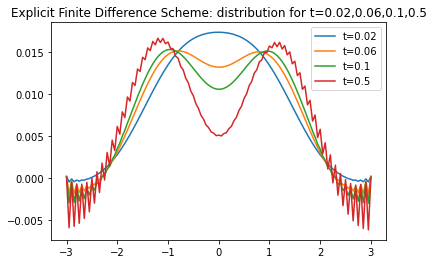

In [26]:
dt = 0.0001  # time step
x = np.linspace(-3, 3, 121) # domain [-3,3] with grid size 0.05
p0 = 1/np.sqrt(2*np.pi)*np.exp(-x**2/2) # initial condition
p0 = p0/sum(abs(p0)) # normalization

gradV = lambda x : 4*x*(x**2-1)+0.1  # gradient of V

def p(t):
    '''
    1-d Fokker-Planck PDE for the double-well potential  
    '''
    p = np.zeros(len(p0))
    p_i = p0
    n = int(t/dt) # number of time steps
    D1 = central_diff_matrix(len(p0)) / (2*0.05) # grid size is 0.05
    D2 = D1 @ D1 # second derivative 
    
    for i in range(n):
        p=p_i+ (D1 @ (gradV(x) * p0) + 2 * D2 @ p_i) * dt # beta = 0.5
        p=p/sum(abs(p)) # normalization
        p_i=p
        
    return p

plt.plot(x, p(0.02), label=f"t=0.02")
plt.plot(x, p(0.06), label=f"t=0.06")
plt.plot(x, p(0.1), label=f"t=0.1")
plt.plot(x, p(0.5), label=f"t=0.5")
plt.title("Explicit Finite Difference Scheme: distribution for t=0.02,0.06,0.1,0.5")
plt.legend()
plt.show()

**My Answer: Using (2) Spectral Method**

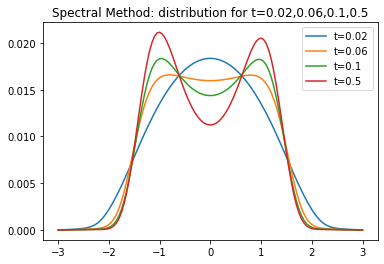

In [27]:
a = p0.tolist()
N = len(a)
w = np.hstack((range(0,int(N/2+1)), range(int(-N/2+1),0)))  # similar to Problem 0
        
def fs(t, y):
    '''
    Frourier spectral method
    '''
    y=np.asarray(y)
    v=gradV(x)*y
    y_f=fft(y)
    v_f=fft(v)
    g=np.zeros(len(y), dtype=np.complex_)
    for i in range(len(y)-1):
         g[i]=-2*w[i]**2*y_f[i]+ w[i]*v_f[i]*1j
    return np.real(ifft(g))

sol1= solve_ivp(fun= fs, t_span=[0,0.02], y0=a, max_step=0.001)
plt.plot(x, np.asarray(sol1.y)[:,-1], label=f"t=0.02")
sol2= solve_ivp(fun= fs, t_span=[0,0.06], y0=a, max_step=0.001)
plt.plot(x, np.asarray(sol2.y)[:,-1], label=f"t=0.06")
sol3= solve_ivp(fun= fs, t_span=[0,0.1], y0=a, max_step=0.001)
plt.plot(x, np.asarray(sol3.y)[:,-1], label=f"t=0.1")
sol4= solve_ivp(fun= fs, t_span=[0,0.5], y0=a, max_step=0.001)
plt.plot(x, np.asarray(sol4.y)[:,-1], label=f"t=0.5")
plt.title("Spectral Method: distribution for t=0.02,0.06,0.1,0.5")
plt.legend()
plt.show()

**Compare the solution $p(x,t)$, the Boltzmann-Gibbs distribution and the histograms you obtained from the samples.**

They are all quite similar. First, the Boltzmann-Gibbs distribution is the invariant distribution of the system. Second, our solution $p(x,t)$ is from the Fokker-Planck equation, which describes the evolution of the distribution of the samples. When $t$ is large, our solution $p(x,t)$ will tend to the invariant distribution, i.e., the Boltzmann-Gibbs distribution. Third, when we draw samples from the distribution $p(x,t)$, we can get the histograms. When then sample size is large in this case, the histograms can be an approximation for the distribution $p(x,t)$. Also, the evoluation of the histograms is also similar to the evoluation of $p(x,t)$, which tends to be invariant.

# Problem 3

[Diffusion map](https://en.wikipedia.org/wiki/Diffusion_map) is another powerful dimensionality reduction method like PCA, MDS and ISOMAP. `one_image.npy` contains one image in the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The following code generates 1000 random rotations of the image. Implement the diffusin map method to extract the 2-dimensional embedding of the digit rotations. Visualize the resulted embedding using the scatter plot.

Hint: Feel free to play with the choice of kernel, number of nearest neighbors to construct the similarity matrix and normalizing parameter $\alpha$.

In [50]:
import numpy as np
import scipy.linalg as la
from skimage.transform import rotate
import matplotlib.pyplot as plt
%matplotlib inline

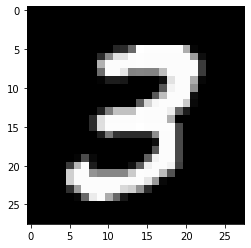

In [51]:
x = np.load('one_image.npy')
plt.imshow(x.reshape((28, 28)), cmap='gray')

In [67]:
# Generate 1000 random rotations of the same image
X   = np.zeros((1000,28*28))
tmp = x.reshape((28, 28))
for i in range(1000):
    X[i,:] = rotate(tmp, np.random.uniform(0,360)).reshape((1,-1))
X   = X/255

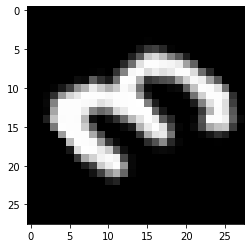

In [68]:
plt.imshow(X[1,:].reshape((28, 28)), cmap='gray')

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import scipy.linalg as la
from sklearn.metrics.pairwise import euclidean_distances

In [70]:
def diffusion_matrix(X=None, alpha=1, epsilon=1):
    """Function to find the diffusion matrix M
        
        >Parameters:
        alpha - normalizing parameter
        epsilon - parameter in the Gaussian Kernel
        X - feature matrix
        
    """
    alpha = alpha
    
    # We choose Gaussian Kernel
    dists = euclidean_distances(X, X)
    L = np.exp(-dists**2/epsilon)
    
    d = np.sum(L, axis=0)
    D = np.diag(d)
    
    # normalize to the new kernel with alpha
    L_alpha = np.diag((d)**(-alpha)) @ L @ np.diag((d)**(-alpha))
    d_alpha = np.sum(L_alpha, axis=0)
    D_alpha = np.diag(d_alpha)
    M = la.inv(D_alpha) @ L_alpha

    return M

In [71]:
def diffusion_map(M, k=2):

    evals, evecs = la.eigh(M)
    L = np.diag(evals[-k:])
    V = evecs[:,-k:]
    
    return V @ L

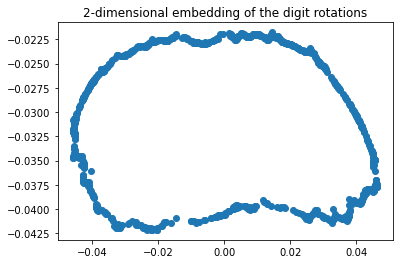

In [72]:
M = diffusion_matrix(X, alpha=0.6, epsilon=1/(2*np.var(X)))
Z = diffusion_map(M, k=2)
plt.scatter(Z[:,0],Z[:,1])
plt.title("2-dimensional embedding of the digit rotations")
plt.show()